In [ ]:
#Example code is from from 04_13_22_Quickdraw_2_Layer_Wopt2_retrained_today

In [2]:
#Standard Imports
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import multiprocess as mp
import PIL
import scipy
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

#Image processing imports (not needed)
from skimage.feature import peak_local_max
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import rotate

#PyTorch Imports (not needed)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision
import piq
from torch.cuda.amp import custom_bwd, custom_fwd

#Data loading Imports
import pandas

In [3]:
#Load all train+validation and test data
data_after_train = np.array(pandas.read_csv(f'Data/Train_Nonlinear_Data_after_intensifier.csv', \
                        delimiter = ',', header = None))
data_after_test = np.array(pandas.read_csv(f'Data/Test_Nonlinear_Data_after_intensifier.csv', \
                        delimiter = ',', header = None))

In [4]:
d_after_train = np.copy(data_after_train)
d_after_test = np.copy(data_after_test)

In [5]:
d_after_train[d_after_train > 4095] = 100
d_after_test[d_after_test > 4095] = 100

In [6]:
#Size of roi windows on camera 3/final measurement camera
size2 = 150

In [7]:
#Checking that the number of images is correct
print(data_after_test.shape[0]/size2/4)
print(data_after_train.shape[0]/size2/4)

505.0
3000.0


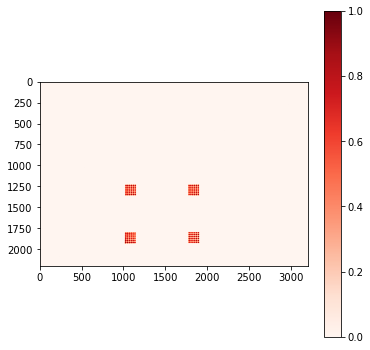

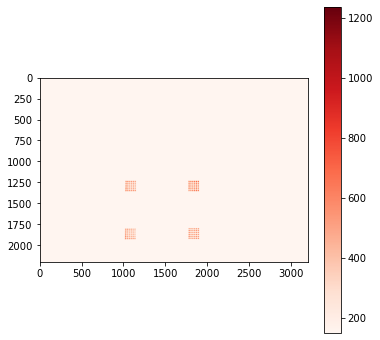

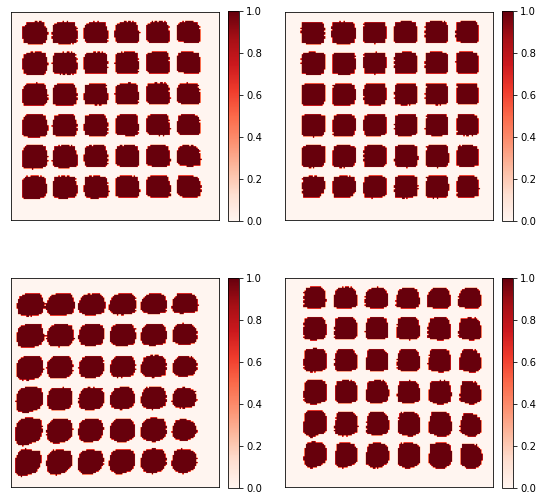

(4, 150, 150)


In [14]:
#Getting thresholded images to create windows for summing the fanned-out copies up

I0_after_int = np.load('I0_reference_after_intensifier_DC.npz')['image']
noise_out = np.load('Noise_reference_after_intensifier_DC.npz')['image']
rois = np.array([[1225, 1375, 1010, 1160], [1225, 1375, 1760, 1910], [1790, 1940, 1010, 1160], [1790, 1940, 1760, 1910]])

#np.heaviside(I0_after_int - 150, 0)#
thresholded = np.heaviside(I0_after_int - 385, 0)
lines_v_after = [102, 179, 258, 333, 412]
lines_after = [121, 200, 278, 359, 435]

plt.figure(figsize = (6, 6))
plt.imshow(thresholded, cmap = 'Reds')
# for k in lines_after:
#     plt.hlines(k, 0, I0_after_int.shape[1], 'k')
# for k in lines_v_after:
#     plt.vlines(k, 0, I0_after_int.shape[0], 'k')
plt.colorbar()
plt.show()

plt.figure(figsize = (6, 6))
plt.imshow(np.maximum(I0_after_int - noise_out, 150), cmap = 'Reds')
plt.colorbar()
plt.show()

fig, ax = plt.subplots(2, 2, figsize = (9, 9))
for p in range (2):
    for q in range (2):
        im = ax[p, q].imshow(thresholded[rois[2*p + q][0]:rois[2*p + q][1], \
                                         rois[2*p + q][2]:rois[2*p + q][3]], cmap = 'Reds')
        plt.colorbar(im, ax = ax[p, q], fraction = 0.046, pad = 0.04)
        ax[p, q].set_xticks([])
        ax[p, q].set_yticks([])
plt.show()

thresholds_roi = []
for q in range (4):
    thresholds_roi.append(thresholded[rois[q][0]:rois[q][1], \
                                      rois[q][2]:rois[q][3]])
thresholds_roi = np.array(thresholds_roi)

noise_roi = []
for q in range (4):
    noise_roi.append(noise_out[rois[q][0]:rois[q][1], \
                                      rois[q][2]:rois[q][3]])
noise_roi = np.array(noise_roi)

print(noise_roi.shape)

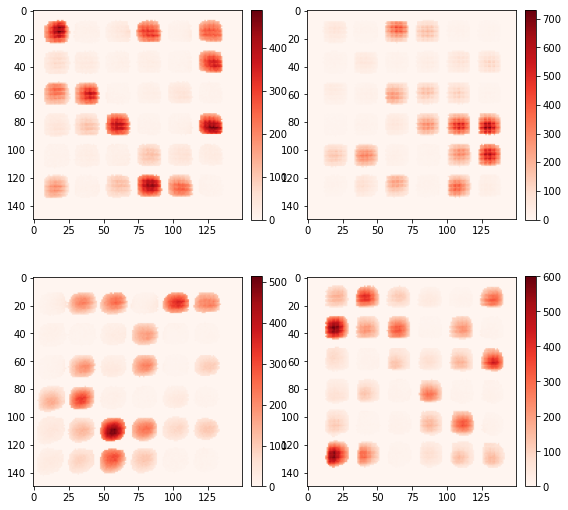

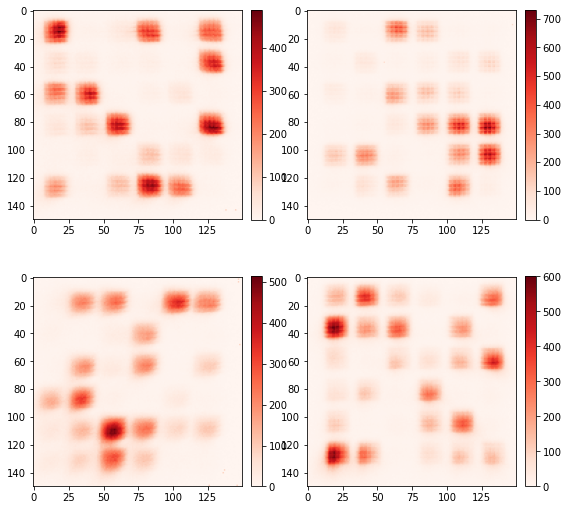

In [15]:
#Looking at threholded images of the 4 compressed neurons - before summing them up
indc = 0
fig, ax = plt.subplots(2, 2, figsize = (9, 9))
for i in range (2):
    for j in range (2):
        ind = 4*indc + 2*i + j
        im = ax[i, j].imshow(np.maximum(thresholds_roi[2*i + j]*d_after_train[ind*size2:(ind+1)*size2], 0), cmap = 'Reds')
        plt.colorbar(im, ax = ax[i, j], fraction = 0.046, pad = 0.04)
plt.show()

fig, ax = plt.subplots(2, 2, figsize = (9, 9))
for i in range (2):
    for j in range (2):
        ind = 4*indc + 2*i + j
        im = ax[i, j].imshow(d_after_train[ind*size2:(ind+1)*size2], cmap = 'Reds')
        plt.colorbar(im, ax = ax[i, j], fraction = 0.046, pad = 0.04)
plt.show()

In [16]:
'''Summing up all the train + validation data in the 4 neurons - just like bucket detectors - 
no image processing involved at all except thresholding'''
train_vectors_fc2 = []
for p in range (3000):
    if (p%100 == 0):
        print(f'{100*p/3000}% done')
    if (p == 2999):
        print('100% done')
    temp = []
    for q in range (4):
        ind = 4*p + q
        temp.append(np.sum(np.maximum(thresholds_roi[q]*d_after_train[ind*size2:(ind+1)*size2], 0)))
    temp = np.array(temp)
    train_vectors_fc2.append(temp)
train_vectors_fc2 = np.array(train_vectors_fc2)
print(train_vectors_fc2.shape)

0.0% done
3.3333333333333335% done
6.666666666666667% done
10.0% done
13.333333333333334% done
16.666666666666668% done
20.0% done
23.333333333333332% done
26.666666666666668% done
30.0% done
33.333333333333336% done
36.666666666666664% done
40.0% done
43.333333333333336% done
46.666666666666664% done
50.0% done
53.333333333333336% done
56.666666666666664% done
60.0% done
63.333333333333336% done
66.66666666666667% done
70.0% done
73.33333333333333% done
76.66666666666667% done
80.0% done
83.33333333333333% done
86.66666666666667% done
90.0% done
93.33333333333333% done
96.66666666666667% done
100% done
(3000, 4)


In [17]:
'''Summing up all the test data in the 4 neurons - just like bucket detectors - 
no image processing involved at all except thresholding'''

test_vectors_fc2 = []
for p in range (505):
    if (p%50 == 0):
        print(f'{100*p/3000}% done')
    if (p == 504):
        print('100% done')
    temp = []
    for q in range (4):
        ind = 4*p + q
        temp.append(np.sum(np.maximum(thresholds_roi[q]*d_after_test[ind*size2:(ind+1)*size2], 0)))
    temp = np.array(temp)
    test_vectors_fc2.append(temp)
test_vectors_fc2 = np.array(test_vectors_fc2)
print(test_vectors_fc2.shape)

0.0% done
1.6666666666666667% done
3.3333333333333335% done
5.0% done
6.666666666666667% done
8.333333333333334% done
10.0% done
11.666666666666666% done
13.333333333333334% done
15.0% done
16.666666666666668% done
100% done
(505, 4)


In [18]:
#Getting the labels
train_labels = np.load('../Datasets/Quick_Draw_GT_images.npz')['train_labels']
test_labels = np.load('../Datasets/Quick_Draw_GT_images.npz')['test_labels']

In [19]:
#Saving the train + validation and the test compressed vectors
np.savez('Train_Data_Quickdraw_Nonlinear', \
                                       train_data_fc2 = train_vectors_fc2, \
                                       train_labels = train_labels)
np.savez('Test_Data_Quickdraw_Nonlinear',
                                      test_data_fc2 = test_vectors_fc2, \
                                      test_labels = test_labels)

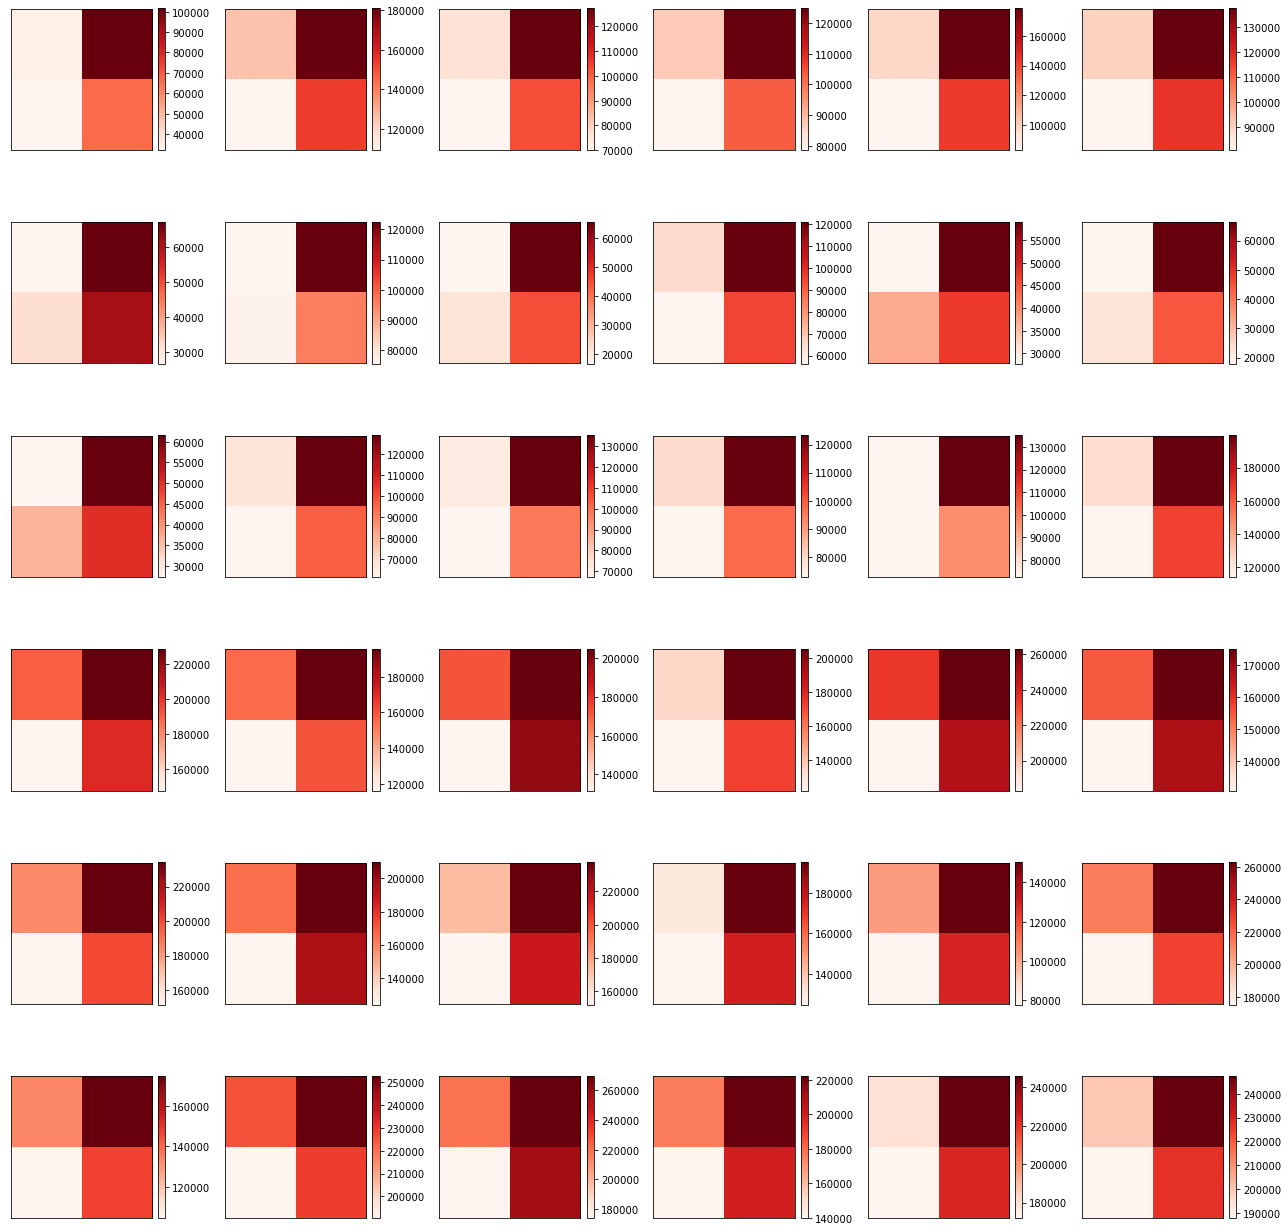

In [57]:
#Plotting the compressed vectors

fig, ax = plt.subplots(6, 6, figsize = (18, 18))
for i in range (6):
    for j in range (6):
        im = ax[i, j].imshow(train_vectors_fc2[600 - 18 + 6*i + j].reshape(2, 2), cmap = 'Reds')
        plt.colorbar(im, ax = ax[i, j], fraction = 0.046, pad = 0.04)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()